In [36]:
import numpy as np
import bayesflow as bf
import matplotlib.pyplot as plt

Running the Bayesflow workflow for a simple linear regression model

We have a simple linear regression model with a single predictor variable $x$ and a single response variable $y$. The model is defined as follows:

(priors)
$$ \alpha \sim \mathcal{N}(0, 1) $$
$$ \beta \sim \mathcal{N}(0, 1) $$
(likelihood)
$$ x \sim \mathcal{N}(0, 1) $$
$$ y \sim \mathcal{N}(\alpha + \beta x, \sigma) $$
$$ \sigma = 1 $$




In [2]:
seed = 1999
RNG = np.random.default_rng(seed)

Defining the prior

In [3]:
def prior_func():
    alpha = RNG.normal()
    beta = RNG.normal()
    return np.r_[alpha, beta]

prior_func()

array([-0.78873063,  0.9836855 ])

In [130]:
prior = bf.simulation.Prior(prior_fun=prior_func, param_names=['alpha', 'beta'])

In [131]:
prior(batch_size=3)

{'prior_draws': array([[-0.70860485, -0.49039188],
        [-0.16175944, -1.60345978],
        [-0.26099332, -0.27170693]]),
 'batchable_context': None,
 'non_batchable_context': None}

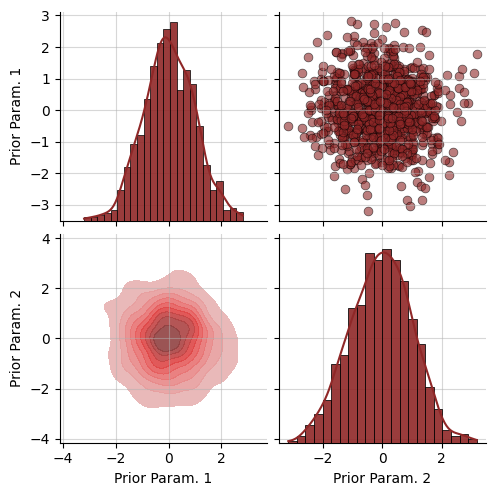

In [7]:
f = prior.plot_prior2d(n_samples=1000)

In [113]:
def likelihood_func(params, n_obs = 100):
    alpha, beta = params
    x = np.random.normal(size=n_obs)
    mean = alpha + beta * x
    y = np.random.normal(loc=mean, size = n_obs)
    return np.column_stack([x, y]) # (n_obs, params.shape[0])

simulator = bf.simulation.Simulator(simulator_fun=likelihood_func)

In [114]:
likelihood_func([0,0], n_obs=10).shape

(10, 2)

In [115]:
model = bf.simulation.GenerativeModel(prior=prior, simulator=simulator)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 100, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [116]:
out = model(batch_size = 2)
out["sim_data"].shape

(2, 100, 2)

In [118]:
summary_net = bf.networks.DeepSet(summary_dim=5)
inference_net = bf.networks.InvertibleNetwork(num_params=2, num_coupling_layers=3,
                                              coupling_settings={"dense_args": dict(kernel_regularizer=None), "dropout": False}, # no L2 and no dropout regularization
)                                

Examples of the summary statistics for 3 batches (by the untrained summary network).

In [119]:
test_input = model(batch_size=3)
summary_rep = summary_net(test_input["sim_data"]).numpy()
summary_rep

array([[-0.00546358,  0.02171338, -0.0282727 ,  0.0004136 ,  0.00596649],
       [-0.00516965,  0.01830085, -0.02526093,  0.00096849,  0.00205727],
       [-0.00181151,  0.01359253, -0.01790921, -0.00033317,  0.00364745]],
      dtype=float32)

In [120]:
z, log_det_J = inference_net(test_input["prior_draws"], summary_rep) # (theta, summary(x))
z.numpy()

array([[-1.0144569 , -1.0592314 ],
       [-0.33284867, -0.91462207],
       [-0.3942959 ,  0.03225125]], dtype=float32)

z represents the latent representation of our parameters, which is constrained to be Gaussian by design:

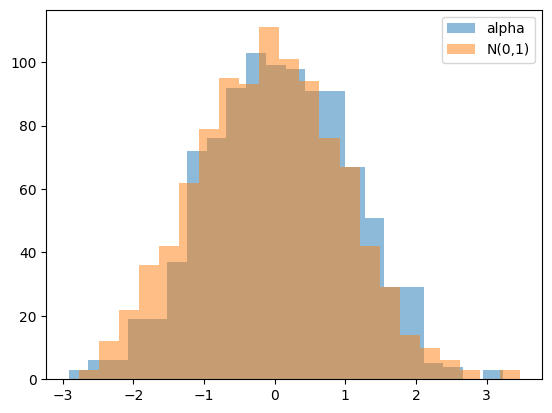

In [94]:
test_input_large = model(batch_size=1000)
summary_rep_large = summary_net(test_input_large["sim_data"]).numpy()
z_large, log_det_J_large = inference_net(test_input_large["prior_draws"], summary_rep_large) # (theta, summary(x))
# plot a histogram of both dimensions of z_large
plt.hist(z_large[:,0], bins=22, alpha=0.5, label="alpha")
# simulate normal distribution with mean 0 and std 1
x = np.random.normal(0, 1, 1000)
plt.hist(x, bins=22, alpha=0.5, label="N(0,1)")
plt.legend()
plt.show()

In [121]:
amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net)
trainer = bf.trainers.Trainer(amortizer=amortizer, generative_model=model)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


Since our data is readily useable for a NN, I do not need to set a manual configurator.

In [122]:
%%time
history = trainer.train_online(epochs=10, iterations_per_epoch=800, batch_size=32, validation_sims=200)

INFO:root:Generated 200 simulations for validation.
Training epoch 1: 100%|██████████| 800/800 [00:15<00:00, 50.63it/s, Epoch: 1, Iter: 800,Loss: 0.807,Avg.Loss: 1.180,LR: 4.88E-04]
INFO:root:Validation, Epoch: 1, Loss: 0.759
Training epoch 2: 100%|██████████| 800/800 [00:12<00:00, 61.83it/s, Epoch: 2, Iter: 800,Loss: 0.112,Avg.Loss: 0.454,LR: 4.52E-04] 
INFO:root:Validation, Epoch: 2, Loss: 0.313
Training epoch 3: 100%|██████████| 800/800 [00:12<00:00, 61.62it/s, Epoch: 3, Iter: 800,Loss: -0.581,Avg.Loss: 0.169,LR: 3.97E-04]
INFO:root:Validation, Epoch: 3, Loss: -0.236
Training epoch 4: 100%|██████████| 800/800 [00:13<00:00, 59.19it/s, Epoch: 4, Iter: 800,Loss: -0.296,Avg.Loss: -0.185,LR: 3.27E-04]
INFO:root:Validation, Epoch: 4, Loss: -0.369
Training epoch 5: 100%|██████████| 800/800 [00:13<00:00, 60.77it/s, Epoch: 5, Iter: 800,Loss: -0.480,Avg.Loss: -0.355,LR: 2.50E-04]
INFO:root:Validation, Epoch: 5, Loss: -0.592
Training epoch 6: 100%|██████████| 800/800 [00:13<00:00, 59.27it/s, E

CPU times: user 3min 32s, sys: 1min 26s, total: 4min 59s
Wall time: 2min 14s


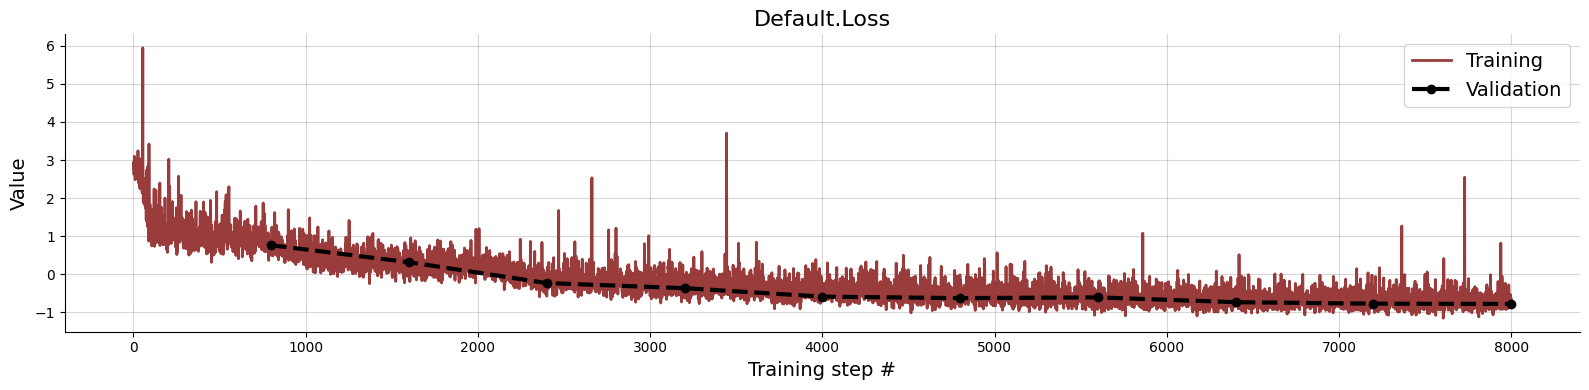

In [123]:
f = bf.diagnostics.plot_losses(history["train_losses"], history["val_losses"], moving_average=True)

In [124]:
test_sims = trainer.configurator(model(500)) # generate 100 unssen data sets
list(test_sims.keys())

['summary_conditions', 'direct_conditions', 'parameters']

In [125]:
posterior_samples = amortizer.sample(test_sims, n_samples=100)
posterior_samples.shape

(500, 100, 2)

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 5.                    Confidence intervals might be unreliable!


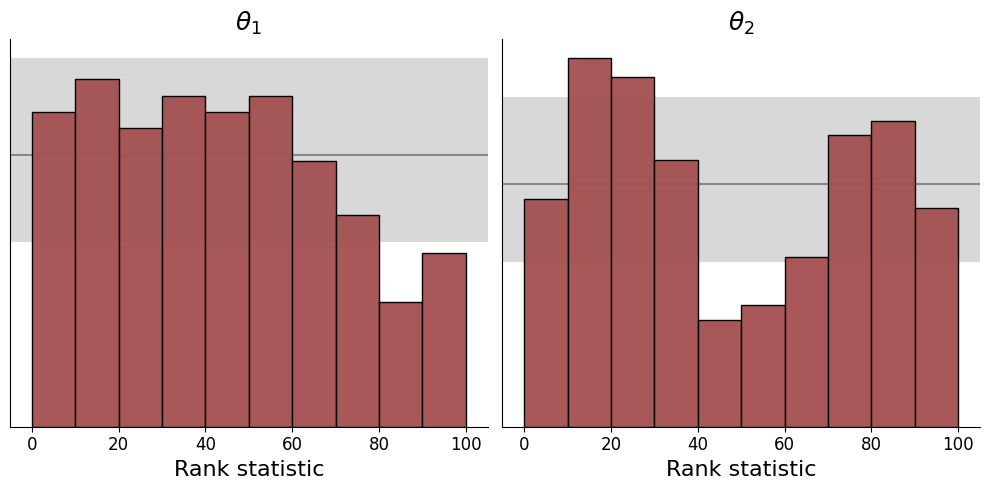

In [126]:
f = bf.diagnostics.plot_sbc_histograms(posterior_samples, test_sims["parameters"], num_bins = 10)

oh boy

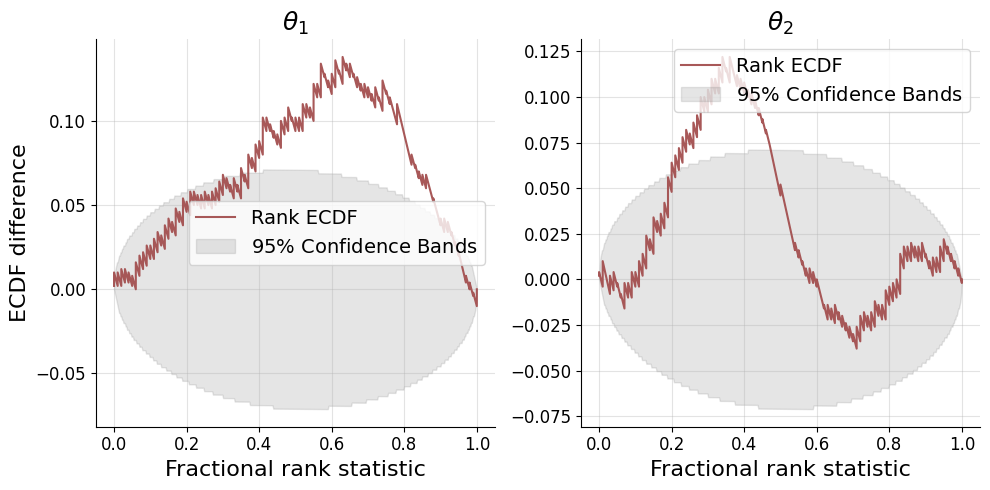

In [127]:
# plotting difference between posterior samples and true parameters
f = bf.diagnostics.plot_sbc_ecdf(posterior_samples, test_sims["parameters"], difference=True)

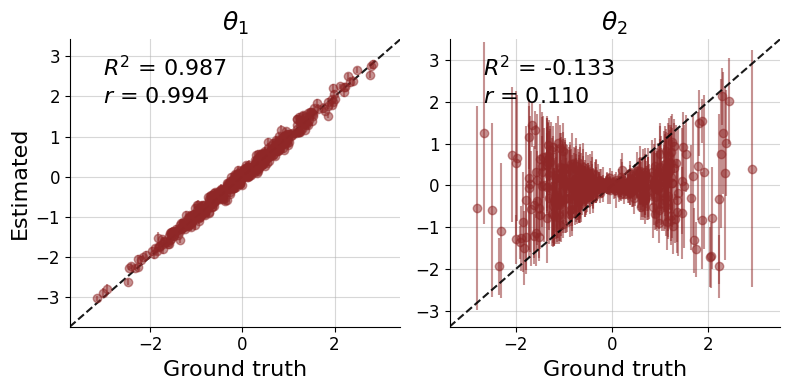

In [128]:
f = bf.diagnostics.plot_recovery(posterior_samples, test_sims["parameters"])

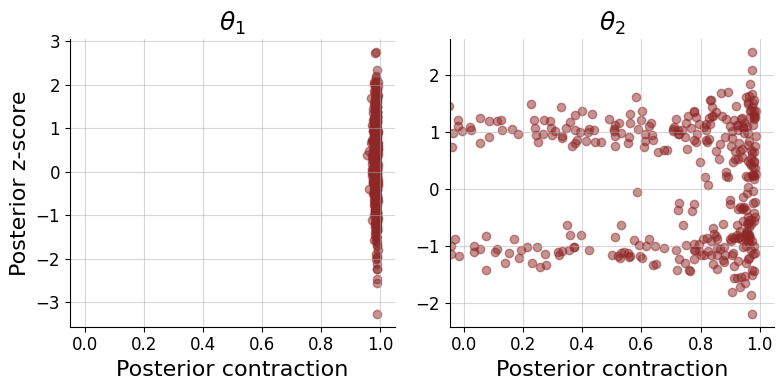

In [129]:
f = bf.diagnostics.plot_z_score_contraction(posterior_samples, test_sims["parameters"])

I am experiement with variouzs network settings, but I keep having this issue that one of my parameters isn't really adequately understood by the model...